### <span style="color:Black">  SENA NUR BILGIN - DSP ASSIGNMENT 1</span>   

**Objective:** 
Here, our goal is to predict the sales price for each house. For each Id in the test set, we will predict the value of the SalePrice variable.

**Target:** 
We will end up calculating Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price.

**Dataset Description:**
- **SalePrice:** Sale Price (in dollars) - Continuous.
- **YearBuilt:** Original construction date - Date/ Temporal Variable
- **YearRemodAdd:** Remodel date (same as construction date if no remodeling or additions) - - Date/ Temporal Variable
- **MasVnrArea:** Masonry veneer area in square feet - Continuous.
- **TotalBsmtSF:** Total square feet of basement area - Continuous.
- **1stFlrSF:** First Floor square feet - Continuous.
- **GrLivArea:** Above grade (ground) living area square feet - Continuous.
- **FullBath:** Full bathrooms above grade - Continuous (Count).
- **TotRmsAbvGrd:** Total rooms above grade (does not include bathrooms) - Continuous (Count).
- **Fireplaces:** Number of fireplaces - Continuous (Count).
- **GarageYrBlt:** Year garage was built - Date (Ordinal)
- **GarageCars:** Size of garage in car capacity - Continuous (Count).
- **GarageArea:** Size of garage in square feet - Continuous.
- **OverallQual:** Rates the overall material and finish of the house - Categorical - Ordinal
  - 10: Very Excellent
  - 9: Excellent
  - 8: Very Good
  - 7: Good
  - 6: Above Average
  - 5: Average
  - 4: Below Average
  - 3: Fair
  - 2: Poor
  - 1: Very Poor
- **GarageFinish:** Interior finish of the garage (Nominal)
  - Fin: Finished
  - RFn: Rough Finished	
  - Unf: Unfinished
  - NA: No Garage
- **KitchenQual:** Kitchen quality (Ordinal)
  - Ex: Excellent
  - Gd: Good
  - TA: Typical/Average
  - Fa: Fair
  - Po: Poor




#### 1. Importing Libraries:

In [89]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler
from scipy.stats import zscore
import warnings


#### 2. Loading Data:

In [90]:

Train_data_raw=pd.read_csv('/Users/xenanurbilgin/DSA-SenaNurBilgin/Data/house-prices-advanced-regression-techniques/train.csv')
Test_data_raw=pd.read_csv('/Users/xenanurbilgin/DSA-SenaNurBilgin/Data/house-prices-advanced-regression-techniques/test.csv')

#### 3. Clean Data:

##### Duplicates:

In [91]:
# Remove duplicate rows
Train_data_raw.drop_duplicates(inplace=True)
Test_data_raw.drop_duplicates(inplace=True)

# Checks:
print(Train_data_raw.shape)
print(Test_data_raw.shape) # we have some duplicates here:



(1460, 81)
(1459, 80)


##### Missing Values/ Checking the Data & Dropping the columns has higher missing value proportion:

In [92]:
Train_data_cleaned=Train_data_raw.copy()
Test_data_cleaned=Test_data_raw.copy()
datasets = [Train_data_cleaned, Test_data_cleaned]
dataset_names = ['Training', 'Test']

for dataset, dataset_name in zip(datasets, dataset_names):
    print(f"Dataset: {dataset_name}")
    # Calculate total number of missing values
    total_missing_values = dataset.isnull().sum().sum()
    # Calculate overall proportion of missing values
    total_entries = dataset.size
    overall_proportion_missing = total_missing_values / total_entries
    # Calculate proportion of missing values for each feature
    missing_values_proportion = dataset.isnull().mean()
    print("Missing values proportion:")
    print(missing_values_proportion)
    # Filter the DataFrame to include only columns where the proportion of missing values is not greater than 0.30
    columns_to_keep = missing_values_proportion[missing_values_proportion <= 0.30].index.tolist()
    dataset = dataset[columns_to_keep]
    
    # Print the updated shape of the dataset
    print(f"Shape after dropping columns with missing values proportion <= 0.3: {dataset.shape}\n")


Dataset: Training
Missing values proportion:
Id               0.000000
MSSubClass       0.000000
MSZoning         0.000000
LotFrontage      0.177397
LotArea          0.000000
                   ...   
MoSold           0.000000
YrSold           0.000000
SaleType         0.000000
SaleCondition    0.000000
SalePrice        0.000000
Length: 81, dtype: float64
Shape after dropping columns with missing values proportion <= 0.3: (1460, 75)

Dataset: Test
Missing values proportion:
Id               0.000000
MSSubClass       0.000000
MSZoning         0.002742
LotFrontage      0.155586
LotArea          0.000000
                   ...   
MiscVal          0.000000
MoSold           0.000000
YrSold           0.000000
SaleType         0.000685
SaleCondition    0.000000
Length: 80, dtype: float64
Shape after dropping columns with missing values proportion <= 0.3: (1459, 74)



##### Dealing with Missing Values:  Here I apply most_frequent method for categorical values, mean for continuous values:


In [93]:
datasets = [Train_data_cleaned, Test_data_cleaned]
dataset_names = ['Training', 'Test']

# Define the imputer strategies
categorical_imputer = SimpleImputer(strategy='most_frequent')
continuous_imputer = SimpleImputer(strategy='mean')

for dataset, dataset_name in zip(datasets, dataset_names):
    print(f"{dataset_name} Dataset:")
    
    # Get the columns with missing values
    cols_with_missing = dataset.columns[dataset.isnull().any()]
    for col in cols_with_missing:
        missing_data_count = dataset[col].isnull().sum()
        print(f"The variable/feature '{col}' has {missing_data_count} missing values.")
    
    # Impute missing values for categorical columns
    categorical_cols = dataset.select_dtypes(include='object').columns
    dataset[categorical_cols] = categorical_imputer.fit_transform(dataset[categorical_cols])
    
    # Impute missing values for numerical columns
    numerical_cols = dataset.select_dtypes(exclude='object').columns
    dataset[numerical_cols] = continuous_imputer.fit_transform(dataset[numerical_cols])

    # Check if there are any remaining missing values after imputation
    remaining_missing_values = dataset.isnull().sum().sum()
    if remaining_missing_values == 0:
        print("All missing values have been imputed successfully.")
    else:
        print(f"There are still {remaining_missing_values} missing values remaining in the dataset.")


Training Dataset:
The variable/feature 'LotFrontage' has 259 missing values.
The variable/feature 'Alley' has 1369 missing values.
The variable/feature 'MasVnrType' has 872 missing values.
The variable/feature 'MasVnrArea' has 8 missing values.
The variable/feature 'BsmtQual' has 37 missing values.
The variable/feature 'BsmtCond' has 37 missing values.
The variable/feature 'BsmtExposure' has 38 missing values.
The variable/feature 'BsmtFinType1' has 37 missing values.
The variable/feature 'BsmtFinType2' has 38 missing values.
The variable/feature 'Electrical' has 1 missing values.
The variable/feature 'FireplaceQu' has 690 missing values.
The variable/feature 'GarageType' has 81 missing values.
The variable/feature 'GarageYrBlt' has 81 missing values.
The variable/feature 'GarageFinish' has 81 missing values.
The variable/feature 'GarageQual' has 81 missing values.
The variable/feature 'GarageCond' has 81 missing values.
The variable/feature 'PoolQC' has 1453 missing values.
The variab

##### Removing abberant data points: Zscore method:


In [94]:
# Remove outliers separately for each numerical column
numeric_columns = ['YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', 
                    'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 
                    'GarageCars', 'GarageArea']

# Remove outliers exceeding 3 standard deviations
threshold = 3

for col in numeric_columns:
    z_scores_train = np.abs((Train_data_cleaned[col] - Train_data_cleaned[col].mean()) / Train_data_cleaned[col].std())
    mask_train = z_scores_train <= threshold
    Train_data_cleaned = Train_data_cleaned[mask_train]

    z_scores_test = np.abs((Test_data_cleaned[col] - Test_data_cleaned[col].mean()) / Test_data_cleaned[col].std())
    mask_test = z_scores_test <= threshold
    Test_data_cleaned = Test_data_cleaned[mask_test]

# Display the shape of the scaled and cleaned training data
print("Shape of the scaled and cleaned training data:", Train_data_cleaned.shape)
print("Shape of the scaled and cleaned test data:", Test_data_cleaned.shape)




Shape of the scaled and cleaned training data: (1384, 81)
Shape of the scaled and cleaned test data: (1363, 80)


### 4.1. Split data:
#### 4.1.1 Selecting Columns:
#### Since we have 2 different set which are Training and Test csv., we can have X_train , y_train, X_valid, y_valid, X_test. We don't have y_test because our objective to predict that, it is not supervised learning, we need to predict unseen data for now. To evaulate model, we need validation data set.

In [95]:
# Separate the training dataset into features (X_train) and the target variable (y_train)

# Training Data Preparation
# Specify the columns to select
selected_columns = ['YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', 
                    'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 
                    'GarageCars', 'GarageArea', "OverallQual", "KitchenQual",
                    "GarageFinish"]

# Select the columns from the dataset
X = Train_data_cleaned[selected_columns]  #  identification of the features.
y  = Train_data_cleaned['SalePrice']  # identification of the label
X_test =  Test_data_cleaned[selected_columns] #  identification of the features.


X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.25,random_state=1)
print("Shape of the scaled and cleaned training data X :", X_train.shape)
print("Shape of the scaled and cleaned training data Y :", y_train.shape)
print("Shape of the scaled and cleaned Validation test data X :", X_valid.shape)
print("Shape of the scaled and cleanedValidation test data  Y :", y_valid.shape)
print("Shape of the scaled and cleaned test data X :", X_test.shape)


Shape of the scaled and cleaned training data X : (1038, 15)
Shape of the scaled and cleaned training data Y : (1038,)
Shape of the scaled and cleaned Validation test data X : (346, 15)
Shape of the scaled and cleanedValidation test data  Y : (346,)
Shape of the scaled and cleaned test data X : (1363, 15)


In [96]:
X_valid.head()

,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,OverallQual,KitchenQual,GarageFinish
323,1955.0,2005.0,0.0,1162.0,1163.0,1163.0,1.0,6.0,0.0,1955.0,1.0,220.0,3.0,TA,Unf
662,1968.0,1968.0,216.0,1392.0,1392.0,1392.0,1.0,5.0,2.0,1968.0,2.0,576.0,6.0,TA,RFn
863,1959.0,1959.0,0.0,1148.0,1148.0,1148.0,1.0,6.0,0.0,1959.0,1.0,672.0,5.0,TA,Unf
1378,1973.0,1973.0,408.0,483.0,483.0,987.0,1.0,5.0,0.0,1973.0,1.0,264.0,6.0,TA,Unf
62,2006.0,2006.0,178.0,1370.0,1370.0,1370.0,2.0,6.0,1.0,2006.0,2.0,484.0,8.0,Gd,RFn


In [97]:
X_train.head()

,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,OverallQual,KitchenQual,GarageFinish
42,1983.0,1983.0,0.0,840.0,884.0,884.0,1.0,5.0,0.0,1983.0,2.0,504.0,5.0,Gd,RFn
1042,2005.0,2005.0,135.0,1306.0,1306.0,1306.0,2.0,5.0,1.0,2005.0,2.0,624.0,6.0,Gd,RFn
104,1931.0,1950.0,600.0,1040.0,1226.0,1818.0,1.0,7.0,2.0,1951.0,1.0,240.0,7.0,TA,Unf
1006,1970.0,1970.0,0.0,1657.0,1657.0,1657.0,2.0,7.0,1.0,1970.0,2.0,484.0,6.0,TA,Unf
807,1923.0,2004.0,0.0,1324.0,1072.0,1576.0,1.0,6.0,1.0,1923.0,2.0,528.0,5.0,Gd,RFn


### 5. Transform data: Encoding labels:

In [98]:
# Ordinal columns
ordinal_cols = ["OverallQual", "KitchenQual", "GarageFinish"]
# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
# Fit and transform ordinal columns for training data
X_train.loc[:, ordinal_cols] = ordinal_encoder.fit_transform(X_train[ordinal_cols])
# Transform ordinal columns for validation data
X_valid.loc[:, ordinal_cols] = ordinal_encoder.transform(X_valid[ordinal_cols])

# Transform ordinal columns for test data
X_test.loc[:, ordinal_cols] = ordinal_encoder.transform(X_test[ordinal_cols])
# Print the first few rows of the transformed training dataset
print("Transformed Training Dataset:")
print(X_train.head())

# Print the first few rows of the transformed validation dataset
print("\nTransformed Validation Dataset:")
print(X_valid.head())

# Print the first few rows of the transformed test dataset
print("\nTransformed Test Dataset:")
print(X_test.head())


Transformed Training Dataset:
      YearBuilt  YearRemodAdd  MasVnrArea  TotalBsmtSF  1stFlrSF  GrLivArea  \
42       1983.0        1983.0         0.0        840.0     884.0      884.0   
1042     2005.0        2005.0       135.0       1306.0    1306.0     1306.0   
104      1931.0        1950.0       600.0       1040.0    1226.0     1818.0   
1006     1970.0        1970.0         0.0       1657.0    1657.0     1657.0   
807      1923.0        2004.0         0.0       1324.0    1072.0     1576.0   

      FullBath  TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  GarageArea  \
42         1.0           5.0         0.0       1983.0         2.0       504.0   
1042       2.0           5.0         1.0       2005.0         2.0       624.0   
104        1.0           7.0         2.0       1951.0         1.0       240.0   
1006       2.0           7.0         1.0       1970.0         2.0       484.0   
807        1.0           6.0         1.0       1923.0         2.0       528.0   

      Ov


### 6. Correlation Matrix:
##### Question 1: Are there some features that are correlated with each other?
#####  Almost all variables/features I picked, has strong linear relationship with the target variable.

In [99]:
merged_data = X_train.merge(y_train, on=X_train.index)
merged_data.drop(columns=['key_0'], inplace=True)
# Calculate the correlation matrix among numeric features
corr = merged_data.corr()
# Apply the gradient color map to the correlation matrix and display it
corr.style.background_gradient(cmap='coolwarm')
# Other good diverging colormaps: 'RdBu_r', 'BrBG_r', & 'PuOr_r'





,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,OverallQual,KitchenQual,GarageFinish,SalePrice
YearBuilt,1.000000,0.629248,0.309309,0.407860,0.292118,0.236396,0.486838,0.107966,0.147416,0.800320,0.556090,0.506716,0.588702,-0.366196,-0.583902,0.583770
YearRemodAdd,0.629248,1.000000,0.168304,0.307719,0.238807,0.291003,0.428366,0.174244,0.084345,0.629896,0.415877,0.370894,0.552774,-0.433030,-0.455045,0.547880
MasVnrArea,0.309309,0.168304,1.000000,0.335736,0.321581,0.310210,0.234339,0.230869,0.238470,0.237675,0.338132,0.334971,0.380019,-0.215731,-0.246831,0.413684
TotalBsmtSF,0.407860,0.307719,0.335736,1.000000,0.774138,0.344182,0.290255,0.200918,0.288328,0.319322,0.436003,0.461215,0.510204,-0.314166,-0.371623,0.622039
1stFlrSF,0.292118,0.238807,0.321581,0.774138,1.000000,0.462419,0.344357,0.330157,0.351938,0.224886,0.440303,0.465390,0.418894,-0.285433,-0.312280,0.589413
GrLivArea,0.236396,0.291003,0.310210,0.344182,0.462419,1.000000,0.609137,0.817596,0.413353,0.235414,0.467543,0.455707,0.561880,-0.304970,-0.347736,0.694236
FullBath,0.486838,0.428366,0.234339,0.290255,0.344357,0.609137,1.000000,0.521650,0.192240,0.458410,0.453949,0.394257,0.521080,-0.309644,-0.424614,0.549345
TotRmsAbvGrd,0.107966,0.174244,0.230869,0.200918,0.330157,0.817596,0.521650,1.000000,0.273574,0.127013,0.345404,0.308860,0.392018,-0.187712,-0.220341,0.489637
Fireplaces,0.147416,0.084345,0.238470,0.288328,0.351938,0.413353,0.192240,0.273574,1.000000,0.029208,0.279492,0.241726,0.347377,-0.180318,-0.285714,0.439574
GarageYrBlt,0.800320,0.629896,0.237675,0.319322,0.224886,0.235414,0.458410,0.127013,0.029208,1.000000,0.479661,0.475576,0.524337,-0.364004,-0.501822,0.501646



### 7. Feature Scaling:


#### Normalization with Min-Max Scaling
#### Note: I also want to include the year column and normalize it along with other numerical features.  I will scale the year values to a range between 0 and 1, where the minimum value corresponds to the earliest year in the dataset and the maximum value corresponds to the latest year. Overall, I can have all values ranged between 0 and 1,  which may make the model's job easier.

In [100]:

numeric_columns = ['YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', 
                    'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 
                    'GarageCars', 'GarageArea']

scaler = StandardScaler()
# Copy the data to avoid modifying the original datasets
X_train_rescaled = X_train.copy()
X_valid_rescaled = X_valid.copy()
X_test_rescaled = X_test.copy()

# Fit and transform the numerical features for training data
X_train_rescaled[numeric_columns] = scaler.fit_transform(X_train_rescaled[numeric_columns])
# Transform the numerical features for validation and test data
X_valid_rescaled[numeric_columns] = scaler.transform(X_valid_rescaled[numeric_columns])
X_test_rescaled[numeric_columns] = scaler.transform(X_test_rescaled[numeric_columns])


In [101]:
X_test_rescaled.head()

,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,OverallQual,KitchenQual,GarageFinish
0,-0.369451,-1.140014,-0.629331,-0.400982,-0.726801,-1.282604,-1.006164,-0.929195,-0.968094,-0.741720,-1.022558,1.331141,4.0,3.0,2.0
1,-0.470975,-1.284700,0.162087,0.763585,0.550136,-0.308630,-1.006164,-0.252824,-0.968094,-0.867197,-1.022558,-0.752577,5.0,2.0,2.0
2,0.848837,0.644441,-0.629331,-0.281138,-0.632431,0.366178,0.848895,-0.252824,0.655301,0.764013,0.364913,0.094868,4.0,3.0,0.0
3,0.882678,0.644441,-0.482772,-0.286349,-0.638329,0.309944,0.848895,0.423546,0.655301,0.805839,0.364913,0.035048,5.0,2.0,0.0
4,0.679630,0.355070,-0.629331,0.635925,0.405633,-0.418849,0.848895,-0.929195,-0.968094,0.554884,0.364913,0.214507,7.0,2.0,1.0


In [102]:
X_test_rescaled.head()

,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,OverallQual,KitchenQual,GarageFinish
0,-0.369451,-1.140014,-0.629331,-0.400982,-0.726801,-1.282604,-1.006164,-0.929195,-0.968094,-0.741720,-1.022558,1.331141,4.0,3.0,2.0
1,-0.470975,-1.284700,0.162087,0.763585,0.550136,-0.308630,-1.006164,-0.252824,-0.968094,-0.867197,-1.022558,-0.752577,5.0,2.0,2.0
2,0.848837,0.644441,-0.629331,-0.281138,-0.632431,0.366178,0.848895,-0.252824,0.655301,0.764013,0.364913,0.094868,4.0,3.0,0.0
3,0.882678,0.644441,-0.482772,-0.286349,-0.638329,0.309944,0.848895,0.423546,0.655301,0.805839,0.364913,0.035048,5.0,2.0,0.0
4,0.679630,0.355070,-0.629331,0.635925,0.405633,-0.418849,0.848895,-0.929195,-0.968094,0.554884,0.364913,0.214507,7.0,2.0,1.0



### 8. Check the Y_train distribution:
##### Question 2: Are the target values normally distributed?
##### Applying a logarithmic transformation to the target variable might be useful in scenarios where the target variable's distribution is skewed or has a long tail. Here, we have positively skewed distribution (tail of the distribution extends more towards the right side) It can help make the distribution more symmetric and stabilize the variance, which can improve the performance of certain machine learning models, especially those that assume normality in the target variable's distribution. 


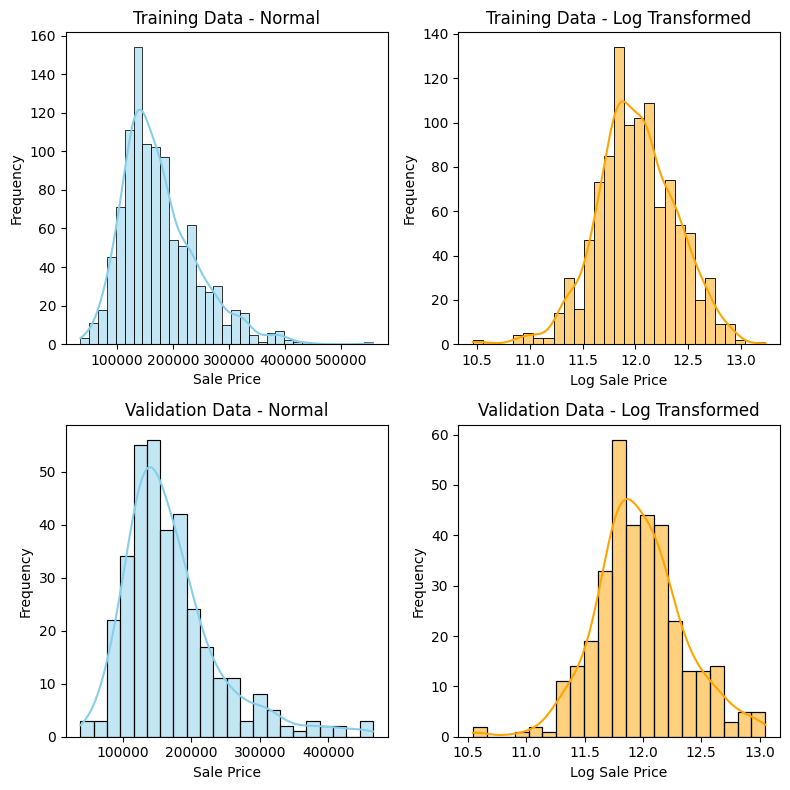

In [103]:

# Log-transform the target variable for training data
y_train_log = np.log(y_train)

# Log-transform the target variable for validation data
y_valid_log = np.log(y_valid)


def plot_target_distribution(y_train, y_valid):
    # Create subplots with a 2x2 grid
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
    
    # Plot training data distribution before log transformation
    sns.histplot(y_train, kde=True, color='skyblue', ax=axes[0, 0])
    axes[0, 0].set_title('Training Data - Normal')
    axes[0, 0].set_xlabel('Sale Price')
    axes[0, 0].set_ylabel('Frequency')
    
    # Plot training data distribution after log transformation
    sns.histplot(np.log(y_train), kde=True, color='orange', ax=axes[0, 1])
    axes[0, 1].set_title('Training Data - Log Transformed')
    axes[0, 1].set_xlabel('Log Sale Price')
    axes[0, 1].set_ylabel('Frequency')
    
    # Plot validation data distribution before log transformation
    sns.histplot(y_valid, kde=True, color='skyblue', ax=axes[1, 0])
    axes[1, 0].set_title('Validation Data - Normal')
    axes[1, 0].set_xlabel('Sale Price')
    axes[1, 0].set_ylabel('Frequency')
    
    # Plot validation data distribution after log transformation
    sns.histplot(np.log(y_valid), kde=True, color='orange', ax=axes[1, 1])
    axes[1, 1].set_title('Validation Data - Log Transformed')
    axes[1, 1].set_xlabel('Log Sale Price')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Call the function with your target variables y_train and y_valid
plot_target_distribution(y_train, y_valid)



### 9. Model Training & Prediction:

In [104]:
regressor = LinearRegression()
regressor.fit(X_train_rescaled, y_train_log)
y_pred_valid = regressor.predict(X_valid_rescaled)
y_pred_test = regressor.predict(X_test_rescaled)
print("Predicted Values - Validation Dataset:", y_pred_valid)
print("Predicted Values- Test Dataset:", y_pred_test)


Predicted Values - Validation Dataset: [11.64503081 12.11753399 11.76217122 11.63089899 12.31326003 12.04628082
 11.40581717 12.90201583 12.26993349 12.08552838 11.71160548 11.86396618
 11.5103721  11.5217402  11.75432681 11.76390401 11.6439595  12.08852167
 12.66367227 11.82361793 11.97993211 12.04502211 12.29458991 11.50050047
 11.56550981 11.91690732 11.77491265 11.74410922 12.02086463 11.96421697
 12.25415942 12.06119651 12.55024106 11.74945551 12.14079784 11.98503987
 12.05583    12.20504678 11.69677152 11.91245441 12.17824915 11.62325272
 12.08739233 12.59601194 12.2224967  12.30512112 12.40842156 12.14376135
 11.85113732 11.58386903 11.75109164 11.64631819 12.49508701 11.79434012
 11.53835899 12.1833055  12.21307975 12.10514082 12.08705847 11.54272058
 12.20347841 12.35989508 11.1938103  11.99281209 12.2193184  12.65252794
 11.95499671 11.59740865 11.91081329 12.25461307 12.10268905 12.15103439
 11.49369776 12.04375931 11.9045748  11.63613409 11.47098913 11.759751
 11.47567709 1

### 10. Model Parameters:

In [105]:
def compute_rmsle(y_test: np.ndarray, y_pred: np.ndarray, precision: int = 2) -> float:
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    return round(rmsle, precision)

In [106]:
rmsle_value = compute_rmsle(y_valid_log, y_pred_valid, precision=3)
print("RMSLE:", rmsle_value)

RMSLE: 0.011


#### Result:
In summary, an RMSLE value of 0.011 suggests that the model's predictions are reasonably close to the actual values.

In [107]:
# Calculate mean squared error (MSE)
MSE = mean_squared_error(y_valid_log, y_pred_valid)
# Calculate root mean squared error (RMSE)
RMSE = mean_squared_error(y_valid_log, y_pred_valid, squared=False)
# Calculate mean absolute error (MAE)
MAE = mean_absolute_error(y_valid_log, y_pred_valid)
print("Mean Squared Error (MSE):", MSE)
print("Root Mean Squared Error (RMSE):", RMSE)
print("Mean Absolute Error (MAE):", MAE)
print("R2-score: %.2f" % r2_score(y_valid_log , y_pred_valid))



Mean Squared Error (MSE): 0.020326913683793038
Root Mean Squared Error (RMSE): 0.14257248571794293
Mean Absolute Error (MAE): 0.10490598097729076
R2-score: 0.86


/Users/xenanurbilgin/miniconda3/envs/DSPSena/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Results:
The Mean Squared Error (MSE) of 0.0203 indicates that, on average, the squared difference between the predicted and actual values is relatively low, implying good model performance in minimizing errors. The Root Mean Squared Error (RMSE) of 0.1426 represents the average magnitude of these errors in the same units as the target variable, which is a reasonably small value, suggesting precise predictions. The Mean Absolute Error (MAE) of 0.1049 signifies that, on average, the absolute difference between predicted and actual values is relatively small, offering a clearer understanding of prediction errors with less influence from outliers. Additionally, the R2-score of 0.86 suggests that approximately 86% of the variance in the target variable is explained by the independent variables in the model, indicating a strong explanatory power and a high level of predictability. Together, these metrics provide comprehensive insights into different aspects of model performance, indicating its effectiveness in making accurate predictions and explaining variability in the target variable.

### 11. Model Visualization:

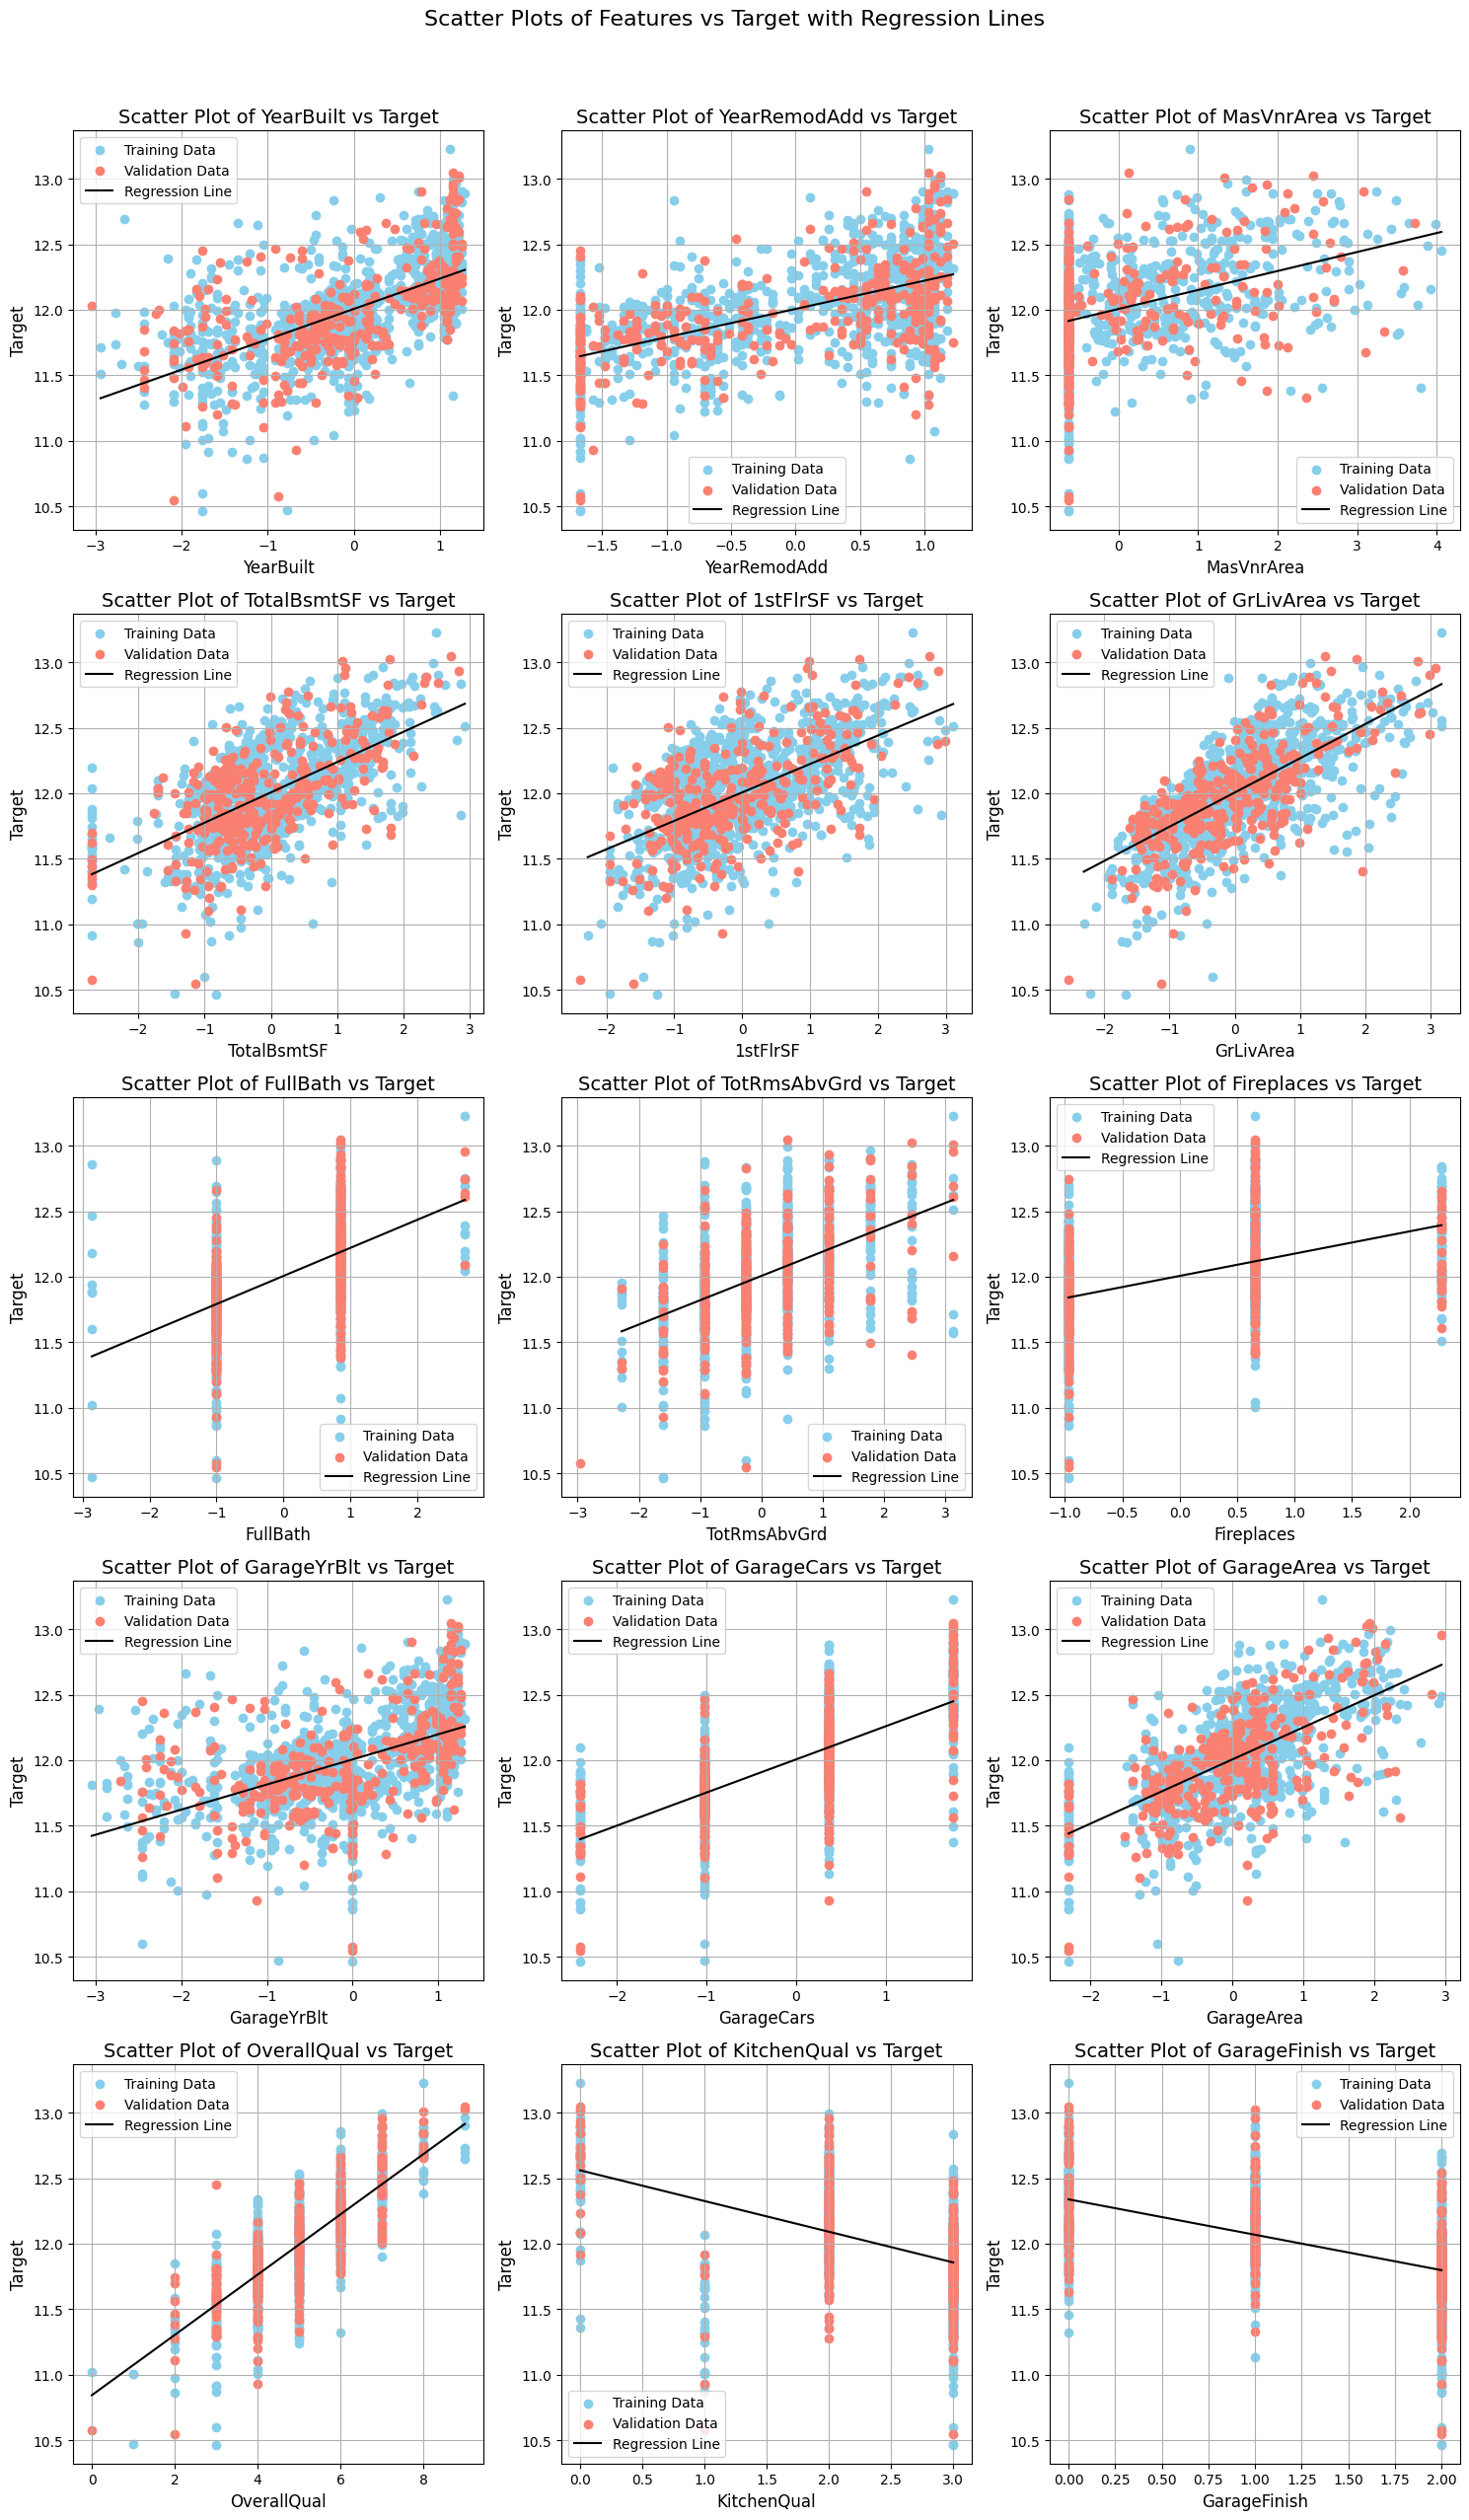

In [108]:


# Suppress specific UserWarnings
warnings.filterwarnings("ignore", message="X does not have valid feature names", category=UserWarning)

# Define the number of rows and columns for subplots
n_rows = (len(X_train_rescaled.columns) + 2) // 3
n_cols = min(len(X_train_rescaled.columns), 3)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through each feature column and create scatter plot with regression line
for i, col in enumerate(X_train_rescaled.columns):
    ax = axes[i]
    ax.scatter(X_train_rescaled[col], y_train_log, label='Training Data', color='skyblue', marker='o')
    ax.scatter(X_valid_rescaled[col], y_valid_log, label='Validation Data', color='salmon', marker='o')
    
    # Fit linear regression model
    regressor.fit(X_train_rescaled[[col]], y_train_log)
    
    # Predictions
    x_values = np.linspace(X_train_rescaled[col].min(), X_train_rescaled[col].max(), 100)
    y_values = regressor.predict(x_values.reshape(-1, 1))
    
    # Plot regression line
    ax.plot(x_values, y_values, color='black', linestyle='-', label='Regression Line')
    
    ax.set_title(f'Scatter Plot of {col} vs Target', fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Target', fontsize=12)
    ax.legend()
    ax.grid(True)

# Hide empty subplots
for i in range(len(X_train.columns), n_rows * n_cols):
    fig.delaxes(axes[i])

# Add a title to the entire plot
plt.suptitle('Scatter Plots of Features vs Target with Regression Lines', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()
